<a href="https://colab.research.google.com/github/kanwal-thurro/cohere-demo/blob/main/cohere-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision-RAG - Cohere Embed v4 & Cmd-A-Vision

RAG so far has been mostly done on text. For rich multimedia files like PDFs it often required complex OCR pre-processing steps and dropping relevant graphics from your RAG pipeline.

This notebook shows a pure **vision-based RAG** approach, that even works for complex infographics.

It consists of two components:

*   **Retrieval:** Here we use the state-of-the-art text & image retrieval model [Embed v4](https://cohere.com/blog/embed-4) by Cohere. It allows us to embed and search complex images, like infographics, without any pre-processing.
*   **Vision-LLM:** Here we use [Command A Vision](https://cohere.com/blog/command-a-vision) by. It allows images & text questions as inputs, and is able to answer questions based on it.




## Setup Cohere for Retrieval

Go to [cohere.com](https://cohere.com) and get an API key.

In [1]:
# !pip install -q cohere

In [2]:
# Create the Cohere API client. Get your API key from cohere.com
import cohere
cohere_api_key = "Qsdl5koOrEqLLEOFmDBgaWcW3BJ0TI4dDUyH1opn" #Replace with your Cohere API key
co = cohere.ClientV2(api_key=cohere_api_key)

In [3]:
# Wrap long longs in this Notebook
from IPython.display import HTML, display

def set_css(info):
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [4]:
import re

def remove_markdown(text):
    # Remove code blocks
    text = re.sub(r'```[\s\S]*?```', '', text)
    # Remove inline code
    text = re.sub(r'`[^`]*`', '', text)
    # Remove images
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
    # Remove links but keep the link text
    text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
    # Remove bold and italic formatting
    text = re.sub(r'(\*\*|__)(.*?)\1', r'\2', text)
    text = re.sub(r'(\*|_)(.*?)\1', r'\2', text)
    # Remove headings
    text = re.sub(r'^#{1,6}\s*', '', text, flags=re.MULTILINE)
    # Remove blockquotes
    text = re.sub(r'^>\s?', '', text, flags=re.MULTILINE)
    # Remove horizontal rules
    text = re.sub(r'(-{3,}|_{3,}|\*{3,})', '', text)
    # Remove unordered list markers
    text = re.sub(r'^[-*+]\s+', '', text, flags=re.MULTILINE)
    # Remove ordered list markers
    text = re.sub(r'^\d+\.\s+', '', text, flags=re.MULTILINE)

    return text.strip()

# Image Search

This section will load several infographics from [appeconomyinsights.com](https://www.appeconomyinsights.com/).

For each image we will call [Cohere Embed v4]((https://cohere.com/blog/embed-4) to get an embeddings. This embedding allows us later to perform search to find relevant images for our questions.

In [5]:
import requests
import os
import io
import base64
from PIL import Image
import tqdm
import time
import numpy as np
from datetime import date

In [6]:
# Some helper functions to resize images and to convert them to base64 format
max_pixels = 1568*1568  #Max resolution for images

# Resize too large images
def resize_image(pil_image):
    org_width, org_height = pil_image.size

    # Resize image if too large
    if org_width * org_height > max_pixels:
        scale_factor = (max_pixels / (org_width * org_height)) ** 0.5
        new_width = int(org_width * scale_factor)
        new_height = int(org_height * scale_factor)
        pil_image.thumbnail((new_width, new_height))

# Convert images to a base64 string before sending it to the API
def base64_from_image(img_path):
    pil_image = Image.open(img_path)
    img_format = pil_image.format if pil_image.format else "PNG"

    resize_image(pil_image)

    with io.BytesIO() as img_buffer:
        pil_image.save(img_buffer, format=img_format)
        img_buffer.seek(0)
        img_data = f"data:image/{img_format.lower()};base64,"+base64.b64encode(img_buffer.read()).decode("utf-8")

    return img_data



In [7]:
# Several images from https://www.appeconomyinsights.com/
images = {
    "tesla.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fbef936e6-3efa-43b3-88d7-7ec620cdb33b_2744x1539.png",
    "netflix.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F23bd84c9-5b62-4526-b467-3088e27e4193_2744x1539.png",
    "nike.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa5cd33ba-ae1a-42a8-a254-d85e690d9870_2741x1541.png",
    "google.png": "https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F395dd3b9-b38e-4d1f-91bc-d37b642ee920_2741x1541.png",
    "accenture.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F08b2227c-7dc8-49f7-b3c5-13cab5443ba6_2741x1541.png",
    "tecent.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0ec8448c-c4d1-4aab-a8e9-2ddebe0c95fd_2741x1541.png"
}

In [8]:
# Download the images and compute an embedding for each image
img_folder = "img"
os.makedirs(img_folder, exist_ok=True)

img_paths = []
doc_embeddings = []
for name, url in tqdm.tqdm(images.items()):
    img_path = os.path.join(img_folder, name)
    img_paths.append(img_path)

    # Download the image
    if not os.path.exists(img_path):
        response = requests.get(url)
        response.raise_for_status()

        with open(img_path, "wb") as fOut:
            fOut.write(response.content)

    # Get the base64 representation of the image
    api_input_document = {
        "content": [
            {"type": "image", "image": base64_from_image(img_path)},
        ]
    }

    # Call the Embed v4.0 model with the image information
    api_response = co.embed(
        model="embed-v4.0",
        input_type="search_document",
        embedding_types=["float"],
        inputs=[api_input_document],
    )

    # Append the embedding to our doc_embeddings list
    emb = np.asarray(api_response.embeddings.float[0])
    doc_embeddings.append(emb)

doc_embeddings = np.vstack(doc_embeddings)
print("\n\nEmbeddings shape:", doc_embeddings.shape)


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]



Embeddings shape: (6, 1536)


## Vision-RAG

The following shows a simple pipeline for vision-based RAG.

1) We first perform search() - We compute the embedding for the question. We can then use that embedding to search through our prevousily embedded images to find the most relevant image. We return this image.

2) In answer(), we send the question + image to Command-A-Vision to give us a final answer to our question

In [11]:
# Search allows us to find relevant images for a given question using Cohere Embed v4
def search(question, max_img_size=800):
    # Compute the embedding for the query
    api_response = co.embed(
        model="embed-v4.0",
        input_type="search_query",
        embedding_types=["float"],
        texts=[question],
    )

    query_emb = np.asarray(api_response.embeddings.float[0])

    # Compute cosine similarities
    cos_sim_scores = np.dot(query_emb, doc_embeddings.T)

    # Get the most relevant image
    top_idx = np.argmax(cos_sim_scores)

    # Show the images
    print("Question:", question)

    hit_img_path = img_paths[top_idx]

    print("Most relevant image:", hit_img_path)
    image = Image.open(hit_img_path)
    max_size = (max_img_size, max_img_size)  # Adjust the size as needed
    image.thumbnail(max_size)
    display(image)
    return hit_img_path

# Answer the question based on the information from the image
# Here we use Command-A-Vision
def answer(question, img_path):
    prompt = f"""Answer the question based on the following image.
For math, use normal text, don't output any latex formulas.
Please provide enough context for your answer.

Question: {question}"""

    response = co.chat(
        model="command-a-vision-07-2025",
        messages=[
             {
                "role": "system",
                "content": [
                    {"type": "text", "text": f"You are an helpful AI assisstant. The current date is {date.today().strftime('%Y-%m-%d')}."},
                ]

            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "image": base64_from_image(img_path)}
                ]

            }
        ]
    )

    answer = response.message.content[0].text.strip()
    print("LLM Answer:")
    print(remove_markdown(answer))

Question: What is the net profit for Nike?
Most relevant image: img/nike.png


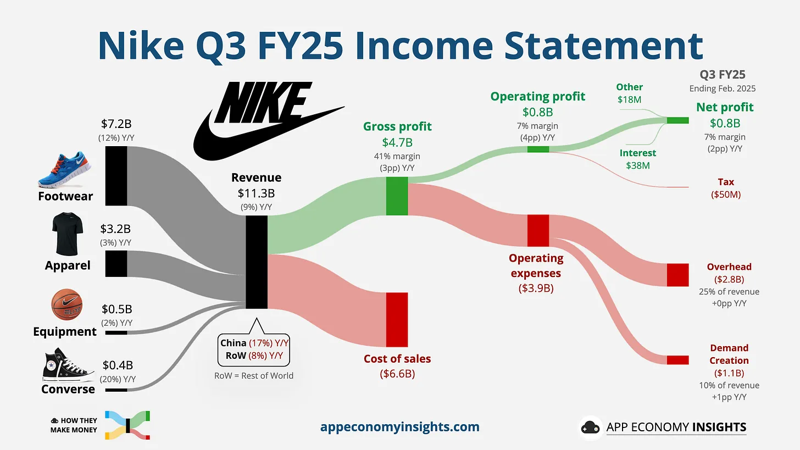

LLM Answer:
The net profit for Nike in Q3 FY25 is $0.8 billion, which represents a 7% margin (2 percentage points year-over-year). This figure is derived after accounting for operating profit ($0.8 billion), interest ($38 million), and tax ($50 million). The net profit is highlighted in the income statement as the final figure after all expenses and adjustments.


In [12]:
# Define the query
question = "What is the net profit for Nike?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: What are the 3 largest acquisitions from Google?
Most relevant image: img/google.png


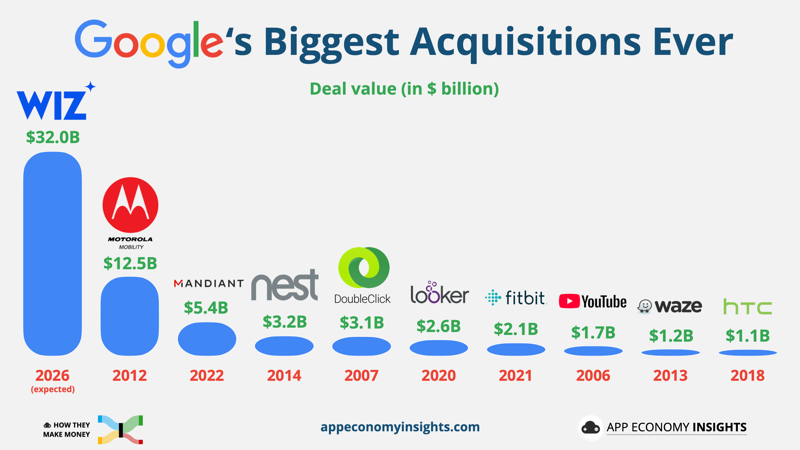

LLM Answer:
The three largest acquisitions by Google, based on the provided image, are:

WIZ (2026, expected): $32.0 billion  
Motorola Mobility (2012): $12.5 billion  
Mandiant (2022): $5.4 billion  

These acquisitions are listed in descending order based on their deal value in billions of dollars.


In [13]:
# Define the query
question = "What are the 3 largest acquisitions from Google?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: How much of the net profit for Tesla was due to interest? What was the percentage?
Most relevant image: img/tesla.png


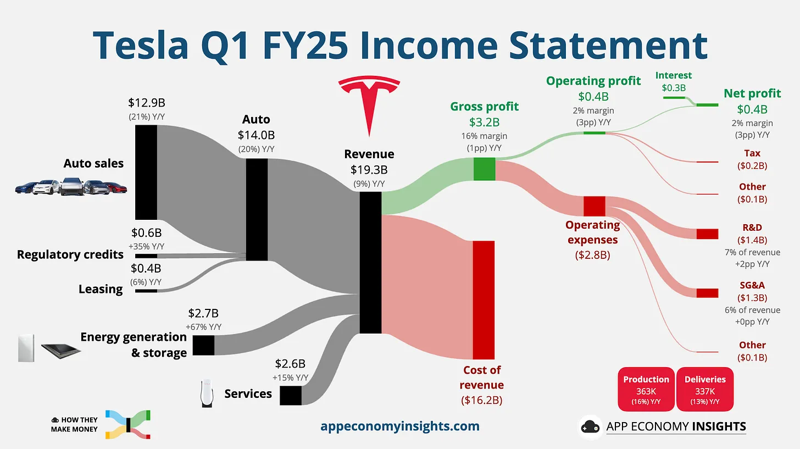

LLM Answer:
To determine how much of Tesla's net profit for Q1 FY25 was due to interest and the corresponding percentage, let's break down the information provided in the income statement:

Net Profit: The net profit for Tesla in Q1 FY25 is $0.4B.
Interest Income: The interest income is listed as $0.3B.

Now, let's calculate the contribution of interest to the net profit and the percentage:

Contribution of Interest to Net Profit:  
  Interest Income = $0.3B  
  Net Profit = $0.4B  
  Contribution = $0.3B / $0.4B = $0.3B

Percentage of Net Profit Due to Interest:  
  Percentage = (Interest Income / Net Profit) * 100  
  Percentage = ($0.3B / $0.4B) * 100 = 75%

Final Answer:
$0.3B of Tesla's net profit for Q1 FY25 was due to interest, which represents 75% of the total net profit.


In [14]:
# Define the query
question = "How much of the net profit for Tesla was due to interest? What was the percentage?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

In [ ]:
# Define the query
question = "Is GenAI a good business for consulting companies?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

In [ ]:
# Define the query
question = "In which region does Netflix generate the highest revenue?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

In [ ]:
# Define the query
question = "How much could tecent grow their revenue year-over-year for the last 5 years?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

In [ ]:
# Define the query
question = "How much money can you make by selling basketballs?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)